In [2]:
import math
import os
import gc
import re
import sys
import time
import json
import random
import datetime
import traceback
import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import leastsq

In [71]:
train = pd.read_csv('../tmp/train/train.csv')
model_global_mean = pd.read_csv('../tmp/train/model_global_mean.csv')
line_k_param = pd.read_csv('../tmp/train/line_k_param.csv')
hedge = pd.read_csv('../tmp/train/hedge.csv')
div_province = pd.read_csv('../tmp/train/div_province.csv')
div_warehouse = pd.read_csv('../tmp/train/div_warehouse.csv')
div_mile = pd.read_csv('../tmp/train/div_mile.csv')

In [72]:
# 根据款型计算中位数
median_price = train.groupby(['brand_area', 'brand_slug', 'model_slug', 'model_detail_slug', 'online_year', 'price_bn'])['price'].median().reset_index().rename(columns={'price': 'median_price'})
median_price = median_price.sort_values(by=['brand_slug', 'model_slug', 'online_year', 'price_bn']).reset_index(drop=True)

median_price['used_years'] = datetime.datetime.now().year - median_price['online_year']
median_price.loc[(median_price['used_years'] < 0), 'used_years'] = 0
median_price['rate'] = median_price['median_price'] / median_price['price_bn']
median_price = median_price.loc[(median_price['rate'] < 1), :].reset_index(drop=True)

In [73]:
column = ['系列']
column.extend(['used_year_'+str(i) for i in range(0,21)])
brand_area = list(set(hedge.brand_area.values))
data = pd.DataFrame([], columns=column)
for brand_area in list(set(hedge.brand_area.values)):
    temp = hedge.loc[(hedge['brand_area'] == brand_area), :].reset_index(drop=True)
    area = [brand_area]
    area.extend(list(temp.hedge.values))
    data = data.append(pd.DataFrame([area], columns=column))
data

,系列,used_year_0,used_year_1,used_year_2,used_year_3,used_year_4,used_year_5,used_year_6,used_year_7,used_year_8,...,used_year_11,used_year_12,used_year_13,used_year_14,used_year_15,used_year_16,used_year_17,used_year_18,used_year_19,used_year_20
0,德系,0.801983,0.753178,0.702802,0.635452,0.561122,0.507622,0.431044,0.375326,0.324299,...,0.214504,0.213343,0.147115,0.128662,0.134570,0.119473,0.106069,0.094169,0.083604,0.074224
0,法系,0.801983,0.747125,0.676773,0.556203,0.515700,0.421256,0.368829,0.320648,0.269397,...,0.159875,0.140234,0.170731,0.151576,0.134570,0.119473,0.106069,0.094169,0.083604,0.074224
0,欧系,0.697329,0.668860,0.610150,0.533579,0.482315,0.424208,0.371809,0.301205,0.268166,...,0.148847,0.152015,0.111359,0.174384,0.157947,0.143059,0.129575,0.117361,0.106299,0.096280
0,美系,0.718232,0.723372,0.638119,0.593975,0.519656,0.462736,0.398704,0.343915,0.293148,...,0.178827,0.181522,0.129534,0.169829,0.153207,0.138213,0.124685,0.112482,0.101473,0.091542
0,韩系,0.801983,0.720721,0.670761,0.603617,0.532319,0.479846,0.441130,0.377636,0.338044,...,0.223881,0.193743,0.136367,0.151576,0.078080,0.119473,0.106069,0.094169,0.083604,0.074224
0,日系,0.860308,0.831316,0.769823,0.712197,0.627285,0.554241,0.481600,0.415606,0.361312,...,0.240642,0.240253,0.175913,0.166252,0.157937,0.107478,0.094376,0.082871,0.072769,0.063898
0,国产,0.830808,0.730689,0.655424,0.571223,0.501044,0.433831,0.371058,0.307882,0.255296,...,0.160643,0.162123,0.165736,0.146408,0.129334,0.114251,0.100927,0.089157,0.078759,0.069575


展示系列: 德系
展示系列: 法系
展示系列: 欧系
展示系列: 美系
展示系列: 韩系
展示系列: 日系
展示系列: 国产


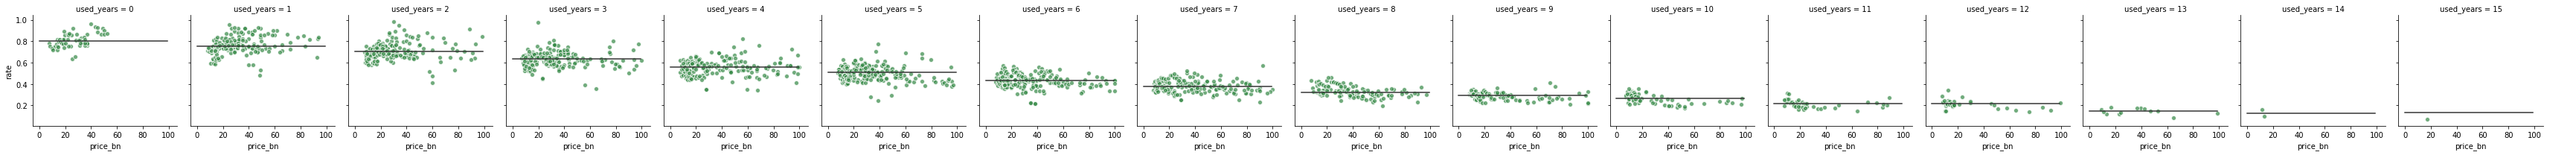

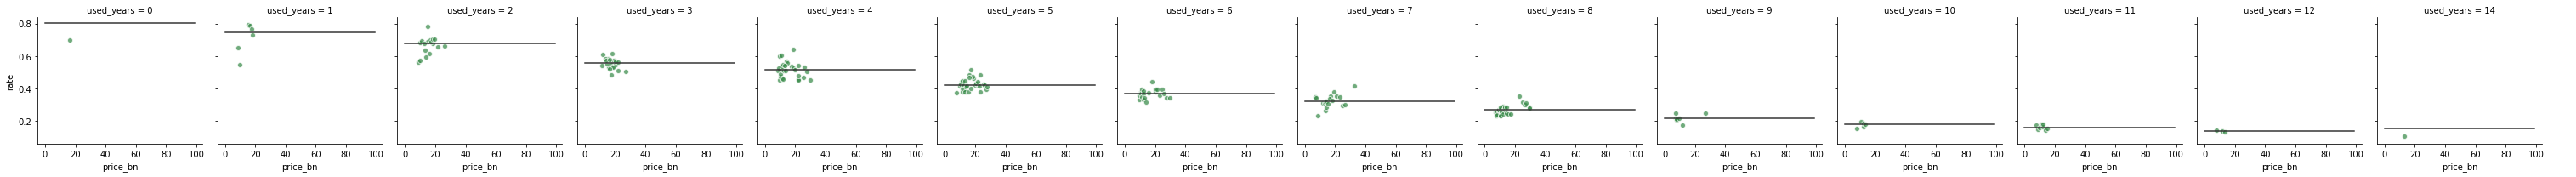

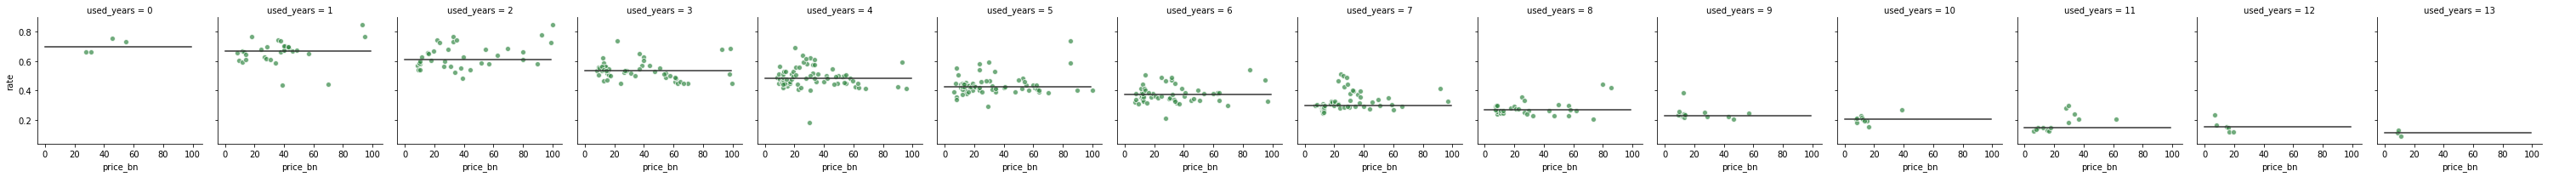

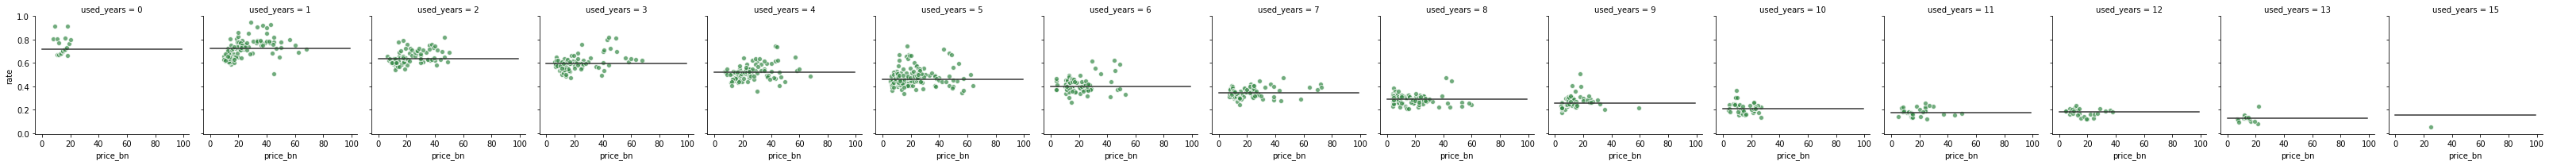

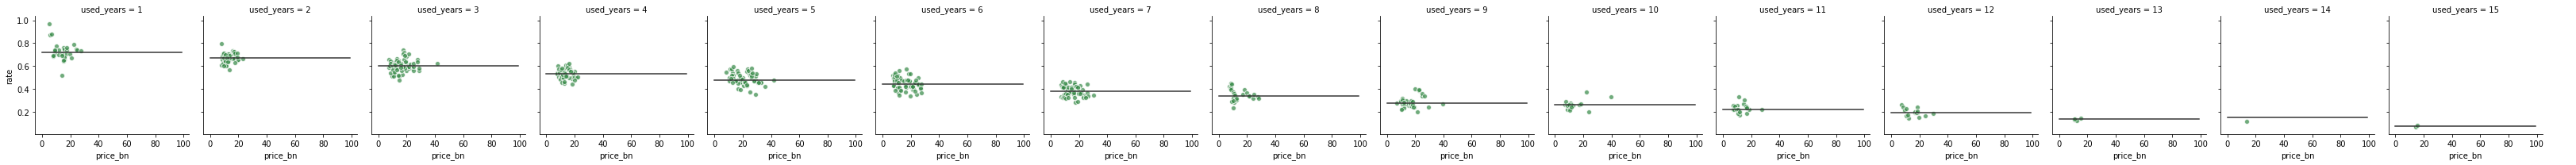

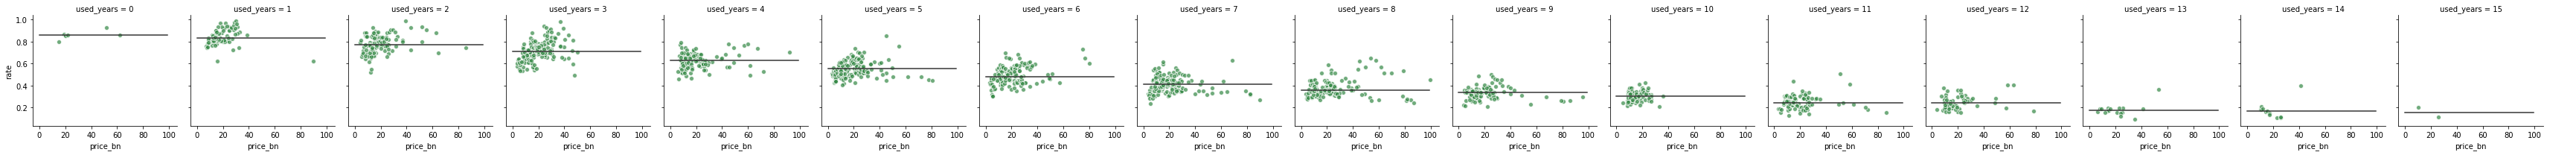

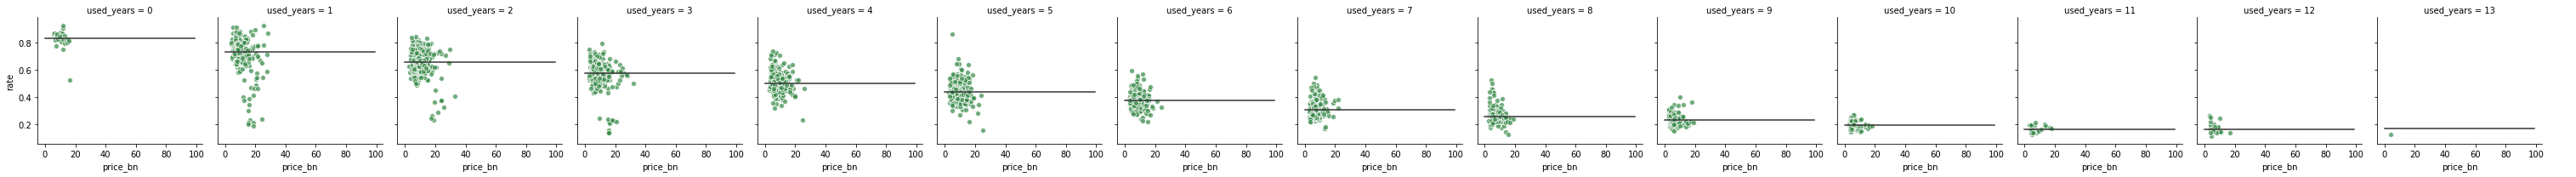

In [78]:
for brand_area in list(set(hedge.brand_area.values)):
    print('展示系列:', brand_area)
    temp = 0
    data = median_price.loc[(median_price['brand_area'] == brand_area)&(median_price['price_bn'] < 100), :].reset_index(drop=True)

    g = sns.FacetGrid(data, col="used_years")
    g.map(plt.scatter, "price_bn", "rate", color="#338844", edgecolor="white", alpha=.7)
#     for i, ax in enumerate(g.axes.flat):
#         print(i)
#         if len(median_price.loc[(median_price['brand_area'] == brand_area)&(median_price['used_years'] == i), :]) <=1:
#             temp= temp + 1
#         k = line_k_param.loc[(line_k_param['brand_area'] == brand_area)&(line_k_param['used_years'] == (i+temp)), ['k']].values[0]
#         x = range(0,100)
#         y = [k if k <= 1 else 1 for i in range(0, 100)]
#         y = [i if i >= 0 else 0 for i in y]
#         ax.plot(x, y, c=".2", ls="--")

    for i, ax in enumerate(g.axes.flat):
        if len(median_price.loc[(median_price['brand_area'] == brand_area)&(median_price['used_years'] == i), :]) < 1:
            temp= temp + 1
        b = hedge.loc[(hedge['brand_area'] == brand_area)&(hedge['used_years'] == i+temp), ['hedge']].values[0]
        x = range(0,100)
        y = [b for i in range(0, 100)]
        ax.plot(x, y, c=".2", ls="-")

    g.add_legend()

In [65]:
line_k_param

,brand_area,used_years,k
0,国产,0,0.830808
1,国产,1,0.730689
2,国产,2,0.655424
3,国产,3,0.571223
4,国产,4,0.501044
5,国产,5,0.433831
6,国产,6,0.371058
7,国产,7,0.307882
8,国产,8,0.255296
9,国产,9,0.231804


In [15]:
model_detail_slug = '110158_autotis'
province = '四川'
warehouse = 1
mile = 2 / 12

median_price = model_global_mean.loc[(model_global_mean['model_detail_slug'] == model_detail_slug), 'predict_price'].values[0]
print('median_price', median_price)

province_price = div_province.loc[(div_province['province'] == province), 'price_div'].values[0] 
print('province_price', province_price)

k = div_warehouse.loc[0, ['k']].values[0]
warehouse_price = k * warehouse
print('warehouse_price', warehouse_price)

k, b = div_mile.loc[0, ['k', 'b']].values
mile_price = k * mile + b
print('mile_price', mile_price)

final_price = median_price + province_price + warehouse_price + mile_price
print('final_price', final_price)

median_price 9.658
province_price 0.0
warehouse_price 0.06856609806397602
mile_price -0.004627078536066885
final_price 9.721939019527907


In [7]:
final_price

5       NaN
26219   NaN
26220   NaN
dtype: float64